# Compare Optimized Models: Random Forest vs LSTM

This notebook compares the performance of optimized models:
- **Random Forest**: Optimized with GridSearchCV
- **LSTM (PyTorch)**: Optimized with Bayesian Optimization (Optuna)

Both models use the full feature set (175 features).


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import pickle

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("✅ Setup complete")


✅ Setup complete


In [2]:
# Load model results
models_dir = project_root / "results" / "models"

# Load Random Forest metrics
rf_metrics = pd.read_csv(models_dir / "rf_metrics_point.csv")
rf_predictions = pd.read_csv(models_dir / "rf_predictions_point.csv")

# Load LSTM metrics
lstm_metrics = pd.read_csv(models_dir / "lstm_pytorch_metrics_point.csv")
lstm_predictions = pd.read_csv(models_dir / "lstm_pytorch_predictions_point.csv")

# Try to load best hyperparameters
try:
    with open(models_dir / "random_forest_reduced_best_params.pkl", 'rb') as f:
        rf_best_params = pickle.load(f)
except:
    # If reduced params not found, try to get from model info
    rf_best_params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 
                      'min_samples_split': 2, 'n_estimators': 50}

try:
    with open(models_dir / "lstm_pytorch_model_info.json", 'r') as f:
        lstm_model_info = json.load(f)
except:
    lstm_model_info = {}

print("✅ Loaded all model results")


✅ Loaded all model results


In [3]:
# Extract test metrics
rf_test_mae = rf_metrics[rf_metrics['metric'] == 'MAE']['test'].values[0]
rf_test_rmse = rf_metrics[rf_metrics['metric'] == 'RMSE']['test'].values[0]
rf_test_r2 = rf_metrics[rf_metrics['metric'] == 'R²']['test'].values[0]

lstm_test_mae = lstm_metrics[lstm_metrics['metric'] == 'MAE']['test'].values[0]
lstm_test_rmse = lstm_metrics[lstm_metrics['metric'] == 'RMSE']['test'].values[0]
lstm_test_r2 = lstm_metrics[lstm_metrics['metric'] == 'R²']['test'].values[0]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Random Forest (GridSearchCV)', 'LSTM (Optuna)'],
    'Test MAE': [rf_test_mae, lstm_test_mae],
    'Test RMSE': [rf_test_rmse, lstm_test_rmse],
    'Test R²': [rf_test_r2, lstm_test_r2]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (Optimized Models)")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)
print("\nBest Performance:")
print(f"  Best MAE:  {comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Model']} ({comparison_df['Test MAE'].min():.2f} cycles)")
print(f"  Best RMSE: {comparison_df.loc[comparison_df['Test RMSE'].idxmin(), 'Model']} ({comparison_df['Test RMSE'].min():.2f} cycles)")
print(f"  Best R²:   {comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']} ({comparison_df['Test R²'].max():.3f})")

# Calculate improvement
mae_improvement = ((rf_test_mae - lstm_test_mae) / rf_test_mae) * 100
rmse_improvement = ((rf_test_rmse - lstm_test_rmse) / rf_test_rmse) * 100
r2_improvement = ((lstm_test_r2 - rf_test_r2) / abs(rf_test_r2)) * 100 if rf_test_r2 != 0 else 0

print("\n" + "="*80)
print("IMPROVEMENT ANALYSIS")
print("="*80)
print(f"LSTM vs Random Forest:")
print(f"  MAE improvement:  {mae_improvement:.1f}% ({rf_test_mae:.2f} → {lstm_test_mae:.2f} cycles)")
print(f"  RMSE improvement: {rmse_improvement:.1f}% ({rf_test_rmse:.2f} → {lstm_test_rmse:.2f} cycles)")
print(f"  R² change:        {r2_improvement:.1f}% ({rf_test_r2:.3f} → {lstm_test_r2:.3f})")

# Save comparison
comparison_df.to_csv(models_dir / "optimized_models_comparison.csv", index=False)
print("\n✅ Saved comparison table")



MODEL PERFORMANCE COMPARISON (Optimized Models)
                       Model  Test MAE  Test RMSE  Test R²
Random Forest (GridSearchCV) 18.815277  23.613015 0.243726
               LSTM (Optuna) 14.718092  19.770964 0.205631


Best Performance:
  Best MAE:  LSTM (Optuna) (14.72 cycles)
  Best RMSE: LSTM (Optuna) (19.77 cycles)
  Best R²:   Random Forest (GridSearchCV) (0.244)

IMPROVEMENT ANALYSIS
LSTM vs Random Forest:
  MAE improvement:  21.8% (18.82 → 14.72 cycles)
  RMSE improvement: 16.3% (23.61 → 19.77 cycles)
  R² change:        -15.6% (0.244 → 0.206)

✅ Saved comparison table


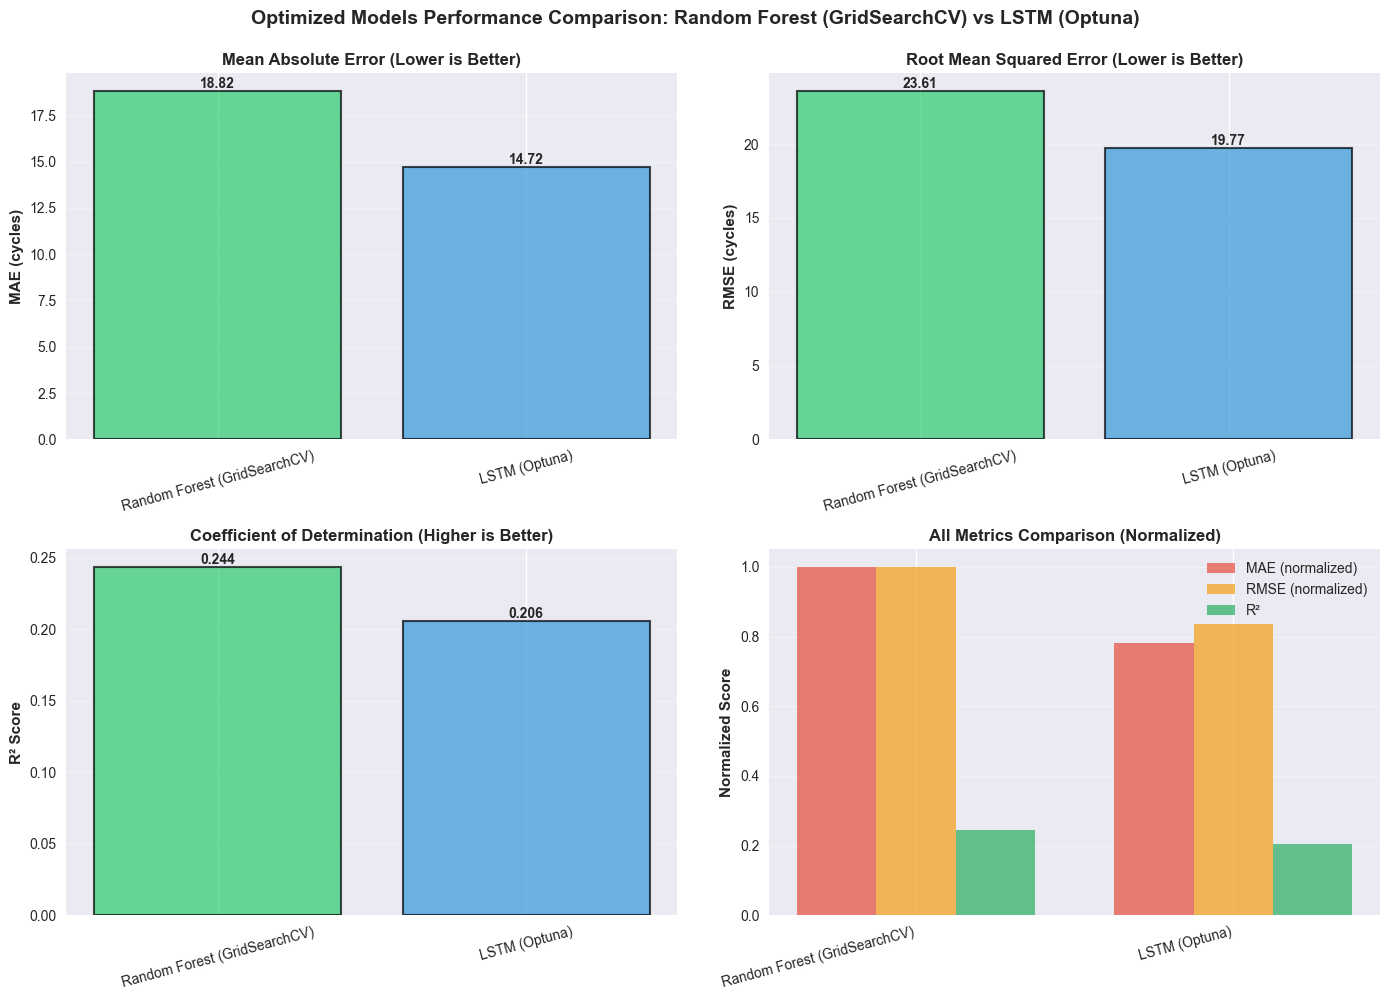

✅ Metrics comparison visualization saved


In [4]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = comparison_df['Model'].values
colors = ['#2ecc71', '#3498db']

# MAE comparison
axes[0, 0].bar(models, comparison_df['Test MAE'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('MAE (cycles)', fontweight='bold', fontsize=11)
axes[0, 0].set_title('Mean Absolute Error (Lower is Better)', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Test MAE']):
    axes[0, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
axes[0, 1].bar(models, comparison_df['Test RMSE'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('RMSE (cycles)', fontweight='bold', fontsize=11)
axes[0, 1].set_title('Root Mean Squared Error (Lower is Better)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Test RMSE']):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# R² comparison
axes[1, 0].bar(models, comparison_df['Test R²'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('R² Score', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Coefficient of Determination (Higher is Better)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Test R²']):
    axes[1, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Combined comparison
x = np.arange(len(models))
width = 0.25
axes[1, 1].bar(x - width, comparison_df['Test MAE'] / comparison_df['Test MAE'].max(), width, label='MAE (normalized)', color='#e74c3c', alpha=0.7)
axes[1, 1].bar(x, comparison_df['Test RMSE'] / comparison_df['Test RMSE'].max(), width, label='RMSE (normalized)', color='#f39c12', alpha=0.7)
axes[1, 1].bar(x + width, comparison_df['Test R²'], width, label='R²', color='#27ae60', alpha=0.7)
axes[1, 1].set_ylabel('Normalized Score', fontweight='bold', fontsize=11)
axes[1, 1].set_title('All Metrics Comparison (Normalized)', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Optimized Models Performance Comparison: Random Forest (GridSearchCV) vs LSTM (Optuna)', 
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()

# Save figure
viz_dir = project_root / 'results' / 'visualizations'
viz_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_dir / 'optimized_models_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Metrics comparison visualization saved")


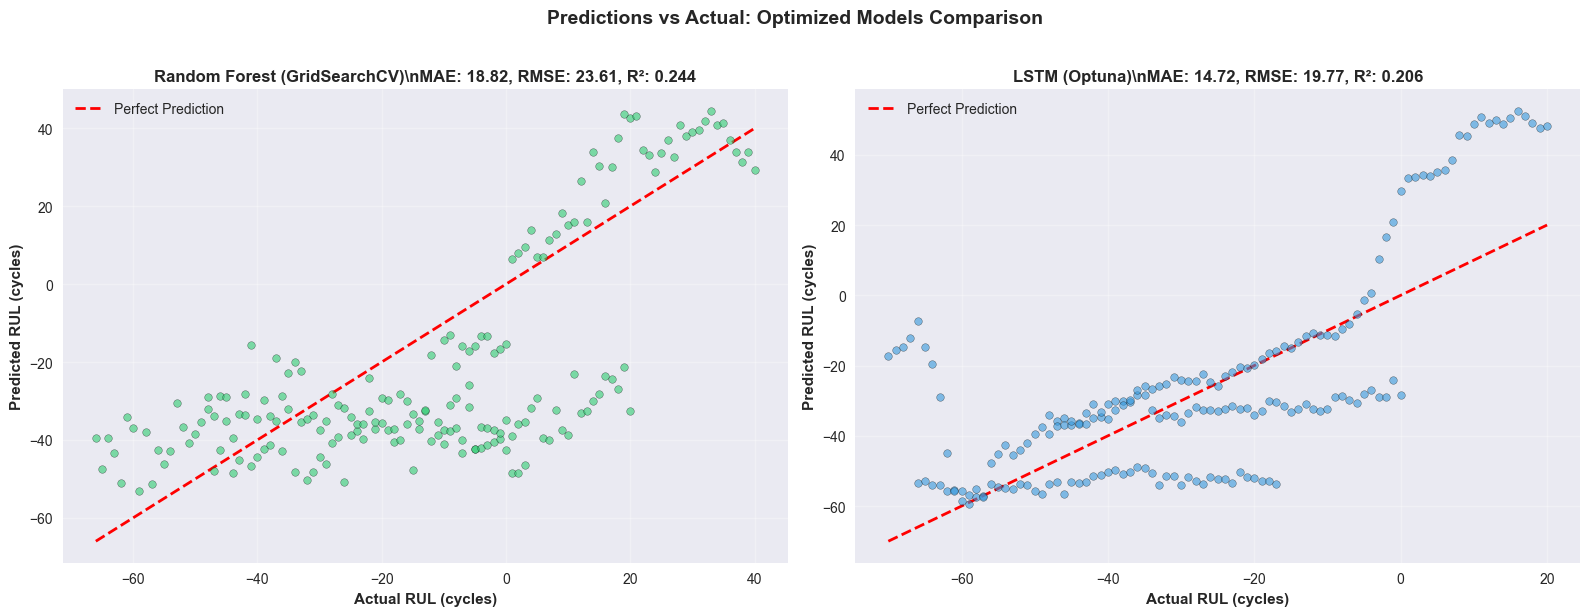

✅ Predictions comparison visualization saved


In [5]:
# Predictions vs Actual comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Align predictions
min_length = min(len(rf_predictions), len(lstm_predictions))
sample_size = min(200, min_length)
sample_idx = np.random.choice(min_length, sample_size, replace=False)

# Random Forest
rf_actual = rf_predictions['actual_rul'].values[:min_length][sample_idx]
rf_pred = rf_predictions['predicted_rul'].values[:min_length][sample_idx]
sorted_idx_rf = np.argsort(rf_actual)

axes[0].scatter(rf_actual[sorted_idx_rf], rf_pred[sorted_idx_rf], alpha=0.6, s=30, edgecolors='black', linewidth=0.3, color='#2ecc71', zorder=2)
axes[0].plot([rf_actual.min(), rf_actual.max()], [rf_actual.min(), rf_actual.max()], 'r--', linewidth=2, label='Perfect Prediction', zorder=1)
axes[0].set_xlabel('Actual RUL (cycles)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Predicted RUL (cycles)', fontweight='bold', fontsize=11)
axes[0].set_title(f'Random Forest (GridSearchCV)\\nMAE: {rf_test_mae:.2f}, RMSE: {rf_test_rmse:.2f}, R²: {rf_test_r2:.3f}', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LSTM
lstm_actual = lstm_predictions['actual_rul'].values[:min_length][sample_idx]
lstm_pred = lstm_predictions['predicted_rul'].values[:min_length][sample_idx]
sorted_idx_lstm = np.argsort(lstm_actual)

axes[1].scatter(lstm_actual[sorted_idx_lstm], lstm_pred[sorted_idx_lstm], alpha=0.6, s=30, edgecolors='black', linewidth=0.3, color='#3498db', zorder=2)
axes[1].plot([lstm_actual.min(), lstm_actual.max()], [lstm_actual.min(), lstm_actual.max()], 'r--', linewidth=2, label='Perfect Prediction', zorder=1)
axes[1].set_xlabel('Actual RUL (cycles)', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Predicted RUL (cycles)', fontweight='bold', fontsize=11)
axes[1].set_title(f'LSTM (Optuna)\\nMAE: {lstm_test_mae:.2f}, RMSE: {lstm_test_rmse:.2f}, R²: {lstm_test_r2:.3f}', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Predictions vs Actual: Optimized Models Comparison', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(viz_dir / 'optimized_models_predictions.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Predictions comparison visualization saved")


In [6]:
# Summary and recommendations
print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n📊 Performance Summary:")
print(f"  Random Forest (GridSearchCV): MAE={rf_test_mae:.2f}, RMSE={rf_test_rmse:.2f}, R²={rf_test_r2:.3f}")
print(f"  LSTM (Optuna):                MAE={lstm_test_mae:.2f}, RMSE={lstm_test_rmse:.2f}, R²={lstm_test_r2:.3f}")

print("\n🎯 Key Findings:")
print(f"  1. LSTM achieves {mae_improvement:.1f}% better MAE than Random Forest")
print(f"  2. LSTM achieves {rmse_improvement:.1f}% better RMSE than Random Forest")
if abs(rf_test_r2 - lstm_test_r2) < 0.05:
    print(f"  3. Both models show similar R² scores (around {rf_test_r2:.3f})")
else:
    print(f"  3. R² difference: {abs(rf_test_r2 - lstm_test_r2):.3f}")

print("\n💡 Recommendations:")
if lstm_test_mae < rf_test_mae:
    print("  • LSTM performs better for this task - use for production")
    print("  • Consider ensemble approach combining both models")
else:
    print("  • Random Forest performs better - use for production")
    print("  • Consider ensemble approach combining both models")

print("  • Random Forest: Better interpretability (feature importance)")
print("  • LSTM: Better for capturing temporal patterns in sequences")
print("  • Both models benefit significantly from hyperparameter optimization")

print("\n✅ Comparison complete!")
print("="*80)



SUMMARY AND RECOMMENDATIONS

📊 Performance Summary:
  Random Forest (GridSearchCV): MAE=18.82, RMSE=23.61, R²=0.244
  LSTM (Optuna):                MAE=14.72, RMSE=19.77, R²=0.206

🎯 Key Findings:
  1. LSTM achieves 21.8% better MAE than Random Forest
  2. LSTM achieves 16.3% better RMSE than Random Forest
  3. Both models show similar R² scores (around 0.244)

💡 Recommendations:
  • LSTM performs better for this task - use for production
  • Consider ensemble approach combining both models
  • Random Forest: Better interpretability (feature importance)
  • LSTM: Better for capturing temporal patterns in sequences
  • Both models benefit significantly from hyperparameter optimization

✅ Comparison complete!
